In [0]:
import tensorflow as tf
import torch

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [0]:
!pip3 install spacy

In [0]:
!pip3 install transformers

     |████████████████████████████████| 389kB 10.0MB/s 
     |████████████████████████████████| 675kB 63.3MB/s 
     |████████████████████████████████| 1.0MB 49.6MB/s 
     |████████████████████████████████| 860kB 60.7MB/s 
  Created wheel for regex: filename=regex-2019.12.9-cp36-cp36m-linux_x86_64.whl size=609192 sha256=9a5f8044adbfcbf3d5144deb7c56fc1d9ea244ff979b9ce8ecdee235cb2bb2b9
  Stored in directory: /root/.cache/pip/wheels/0d/fb/b3/a89169557229468c49ca64f6839418f22461f6ee0a74f342b1
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=dc169cdb1f56f72e8639d459aabfe56b7fc08e10c71ca37e9010b4ecf38b1a32
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built regex sacremoses


In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
from google.colab import files
uploaded = files.upload()

Saving train_all_1.csv to train_all_1.csv
Saving test_all_1.csv to test_all_1.csv
Saving val_all_1.csv to val_all_1.csv


In [0]:
train_df = pd.read_csv("train_all.csv")
test_df = pd.read_csv('test_all.csv')
val_df = pd.read_csv('val_all.csv')

train1_df = pd.read_csv("train_all_1.csv")
test1_df = pd.read_csv('test_all_1.csv')
val1_df = pd.read_csv('val_all_1.csv')


In [0]:
MAX_LEN = 128

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [0]:
import spacy
import re
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
nlp = spacy.load('en')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')


punctuations = string.punctuation


stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    

    # return preprocessed list of tokens
    return " ".join(mytokens)

In [0]:
train_sentences = list(train_df.request_text.values)
val_sentences = list(val_df.request_text.values)

train1_sentences = list(train1_df.request_text.values)
val1_sentences = list(val1_df.request_text.values)

In [0]:
len(train_sentences),  type(train_sentences)

(2714, list)

In [0]:
len(val_sentences), len(val1_sentences)

(905, 1103)

In [0]:
train_sentences = train_sentences + train1_sentences
val_sentences = val_sentences + val1_sentences

In [0]:
len(train_sentences), len(val_sentences)

(6021, 2008)

In [0]:
train_tk_texts = [ [tokenizer.cls_token] + tokenizer.tokenize(sent) + [tokenizer.sep_token] for sent in train_sentences]

val_tk_texts = [ [tokenizer.cls_token] + tokenizer.tokenize(sent) + [tokenizer.sep_token] for sent in val_sentences]



In [0]:
print ("Tokenize the first sentence:")
print (train_tk_texts[100])

Tokenize the first sentence:
['[CLS]', 'i', "'", 'm', 'always', 'competing', 'with', 'madonna', 'and', 'elvis', 'today', '.', 'a', 'birthday', 'pie', 'would', 'certainly', 'lift', 'my', 'spirits', 'today', 'and', 'maybe', '40', 'wouldn', "'", 't', 'look', 'so', 'scary', '.', '[SEP]']


In [0]:
train_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in train_tk_texts]
val_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in val_tk_texts]

train_input_ids = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

val_input_ids = pad_sequences(val_input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")



In [0]:
train_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in train_input_ids:
  seq_mask = [float(i>0) for i in seq]
  train_attention_masks.append(seq_mask)

In [0]:
val_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in val_input_ids:
  seq_mask = [float(i>0) for i in seq]
  val_attention_masks.append(seq_mask)

In [0]:
train_labels = list(train_df.requester_received_pizza.values) +  list(train1_df.requester_received_pizza.values)
val_labels =  list(val_df.requester_received_pizza.values) +  list(val1_df.requester_received_pizza.values)



In [0]:
len(train_labels), len(val_labels)

(6021, 2008)

In [0]:
train_inputs = torch.tensor(train_input_ids)
val_inputs = torch.tensor(val_input_ids)
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_attention_masks)
val_masks = torch.tensor(val_attention_masks)

In [0]:
batch_size = 10

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


In [0]:
torch.cuda.empty_cache()
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
from transformers import get_linear_schedule_with_warmup


optimizer = AdamW(model.parameters(), lr=2e-5)  # To reproduce BertAdam specific behavior set correct_bias=False



In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss, something_else = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in val_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))




Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

In [0]:
logits

array([[ 1.8424044 , -1.0417346 ],
       [ 1.9168675 , -1.0843091 ],
       [-0.10070987, -0.25192615],
       [ 1.3997724 , -0.6581643 ],
       [ 1.0567319 , -0.87730354],
       [ 1.5169766 , -0.9892862 ],
       [-1.0572195 ,  0.38585186],
       [ 1.2616638 , -0.7878411 ]], dtype=float32)

In [0]:
label_ids

array([0, 0, 0, 0, 0, 0, 0, 1])

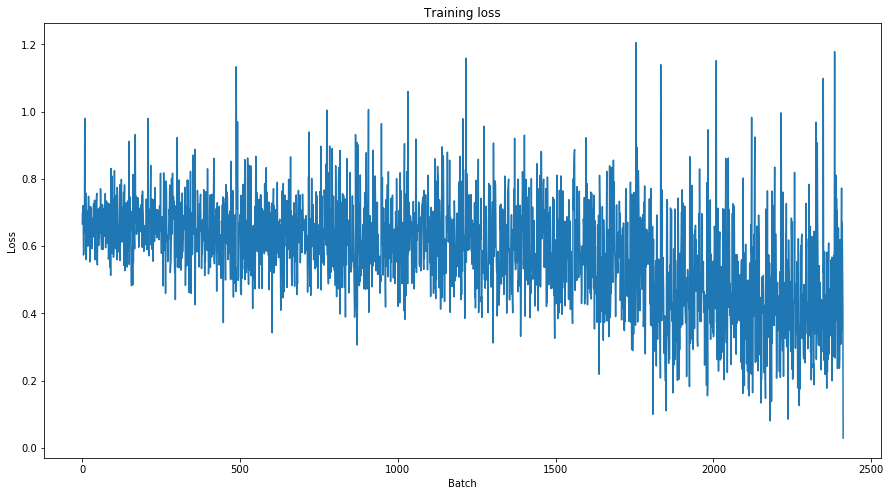

In [0]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()